## Predicting Property Values

Oliver Ton - 03.30.2022

### Summary

Built a machine model to predict single unit property values using Zillow data

### Project Goal

Plan out the project, seeing how square footage, number of bedrooms, number of bathrooms, and house age relate to property value

### Project Overview

- Python scripts were used to automate the process of acquiring, preparing and explorign the data
- The data was cleaned by replacing null values, dropping duplicates, encoding new features and one hot encoding features
    - These steps were taken to create the best performing model (mvp)
    - Outliers in the data were analyzed as weel as the distributions of variables explored in depth 
- The data was split into train, validate and test into 3 dataframes beofre modeling to avoid data leakage and maintain data integrity 
- Recursive feature engineering was utilized to select the top features to be included in the models used to predict property values
- The target variables, tax value, is continuous, used the following regression algorithms to create models that perform better than the baseline:
    - OLS Linear Regression
    - Lasso + Lars
    - Tweedie Regressor GLM
    - Polynomial Regression
- The best model (mvp) was fitted on the test data to predict propter values

In [1]:
#Import
import warnings
warnings.filterwarnings("ignore")

import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import stats

from sklearn.feature_selection import SelectKBest, f_regression, RFE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor

import wrangle as w
import explore as exp
import model as m

## Wrangle

Acquire
- Used a connection URL to access the Codeup database. Used SQL query to brought in the Zillow dataset with only properties set in 2017. 
- Turned it into a Dataframe and created a csv in order to use it for the rest of the pipeline

Cleanning data
- Drop duplicates and null values
- Assure the data types are appropriate
- Rename and make relevant columns like age (2017 - yearbuilt), county (based on fips)
- Handle outlier by dropping any rows with values that were 3 standard deviations above or below the mean
- Split data into train, validate, test, X_train, y_train, X_validate, y_validate, X_test, y_test
        

In [2]:
#Data acquire from Codeup database and then return Zillow data into a dataframe and create a csv 
df = w.get_zillow_data()

In [3]:
#Checking if the function above run as intended 
df.head()

,parcelid,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt,yearbuilt,fips
0,14297519,4.0,3.5,3100.0,1023282.0,1998.0,6059.0
1,17052889,2.0,1.0,1465.0,464000.0,1967.0,6111.0
2,14186244,3.0,2.0,1243.0,564778.0,1962.0,6059.0
3,12177905,4.0,3.0,2376.0,145143.0,1970.0,6037.0
4,12095076,4.0,3.0,2962.0,773303.0,1950.0,6037.0


In [4]:
#Checking datatype of each columns
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52441 entries, 0 to 52440
Data columns (total 7 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   parcelid                      52441 non-null  int64  
 1   bedroomcnt                    52441 non-null  float64
 2   bathroomcnt                   52441 non-null  float64
 3   calculatedfinishedsquarefeet  52359 non-null  float64
 4   taxvaluedollarcnt             52440 non-null  float64
 5   yearbuilt                     52325 non-null  float64
 6   fips                          52441 non-null  float64
dtypes: float64(6), int64(1)
memory usage: 3.2 MB


In [5]:
#Look at the max and min before the clean up adn remove outliers
df.describe().T

,count,mean,std,min,25%,50%,75%,max
parcelid,52441.0,1.299912e+07,3.411444e+06,10711855.0,11510217.0,12577645.0,14129530.00,167687839.0
bedroomcnt,52441.0,3.300681e+00,9.490939e-01,0.0,3.0,3.0,4.00,14.0
bathroomcnt,52441.0,2.299403e+00,1.022772e+00,0.0,2.0,2.0,3.00,18.0
calculatedfinishedsquarefeet,52359.0,1.922891e+03,1.004366e+03,128.0,1268.0,1659.0,2306.00,21929.0
taxvaluedollarcnt,52440.0,5.296882e+05,7.518946e+05,1000.0,193747.5,373612.0,619301.25,49061236.0
yearbuilt,52325.0,1.963394e+03,2.313357e+01,1878.0,1950.0,1961.0,1979.00,2016.0
fips,52441.0,6.049132e+03,2.102907e+01,6037.0,6037.0,6037.0,6059.00,6111.0


In [6]:
#Checking for null values
w.miss_dup_values(df)

Your selected dataframe has 7 columns.
There are 3 columns that have missing values.
  
** There are 121 duplicate rows that represents 0.23% of total Values**


,Missing Values,% of Total Values
yearbuilt,116,0.2
calculatedfinishedsquarefeet,82,0.2
taxvaluedollarcnt,1,0.0


In [7]:
#Clean zillow data: rename columns, drop any duplicates and null values
df = w.clean_zillow(df)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52200 entries, 0 to 52440
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   parcel_id        52200 non-null  object 
 1   number_bedroom   52200 non-null  float64
 2   number_bathroom  52200 non-null  float64
 3   sqft             52200 non-null  float64
 4   tax_value        52200 non-null  float64
 5   geographic_code  52200 non-null  int64  
 6   age              52200 non-null  float64
 7   county           52200 non-null  object 
dtypes: float64(5), int64(1), object(2)
memory usage: 3.6+ MB


In [9]:
#Checking again for null values
w.miss_dup_values(df)

Your selected dataframe has 8 columns.
There are 0 columns that have missing values.
  
** There are 0 duplicate rows that represents 0.0% of total Values**


,Missing Values,% of Total Values


In [10]:
df.head()

,parcel_id,number_bedroom,number_bathroom,sqft,tax_value,geographic_code,age,county
0,14297519,4.0,3.5,3100.0,1023282.0,6059,19.0,Orange
1,17052889,2.0,1.0,1465.0,464000.0,6111,50.0,Ventura
2,14186244,3.0,2.0,1243.0,564778.0,6059,55.0,Orange
3,12177905,4.0,3.0,2376.0,145143.0,6037,47.0,Los Angeles
4,12095076,4.0,3.0,2962.0,773303.0,6037,67.0,Los Angeles


In [11]:
#Remove outliers 
df = w.remove_outlier(df)

In [12]:
#Take a look at the min and max again
df.describe().T

,count,mean,std,min,25%,50%,75%,max
number_bedroom,51504.0,3.289919,0.922327,0.0,3.00,3.0,4.0,12.0
number_bathroom,51504.0,2.266057,0.951437,0.0,2.00,2.0,3.0,10.0
sqft,51504.0,1878.808811,887.229329,128.0,1263.00,1648.0,2274.0,11020.0
tax_value,51504.0,470573.910978,414410.112729,1000.0,191438.75,368905.5,603758.0,2768405.0
geographic_code,51504.0,6049.144377,21.045330,6037.0,6037.00,6037.0,6059.0,6111.0
age,51504.0,53.761533,22.983675,1.0,38.00,57.0,67.0,139.0


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51504 entries, 0 to 52440
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   parcel_id        51504 non-null  object 
 1   number_bedroom   51504 non-null  float64
 2   number_bathroom  51504 non-null  float64
 3   sqft             51504 non-null  float64
 4   tax_value        51504 non-null  float64
 5   geographic_code  51504 non-null  int64  
 6   age              51504 non-null  float64
 7   county           51504 non-null  object 
dtypes: float64(5), int64(1), object(2)
memory usage: 3.5+ MB


In [14]:
#Split the data into 3 dataframes - train, validate and test
#Target variable - tax_value
target = 'tax_value'
train, validate, test, X_train, y_train, X_validate, y_validate, X_test, y_test = w.split_data(df, target)

X_train -> (28842, 7)               y_train->(28842,)
X_validate -> (12361, 7)         y_validate->(12361,) 
X_test -> (10301, 7)                  y_test>(10301,)


Take Away:
- Tax value is our target variable
- Some null values  and extreme outlier in sqft, number_bedroom, number_bathroom, and tax_value which we will explore and decide how to handle
- Parcel id column does not provide much information except serving as a unique id for each row 
- The yearbuilt column seems to have the most missing values
- County can be dummy coded because there are 3 categories
- Median year built is 1971
- Newest home was built in 2016 while the oldest home is from 1878
- Average number of baths around 2
- Average number of beds around 3
- Min number of beds and baths 0
- 0 beds could be a studio but 0 baths is likely an error that will be further explored
- Mean home size is around 1923 square feet
- Most property are in 6037 (LA)

## Explore

Visualize the data. Explore relationships. Find answers. Use the visuals and statistics test to helps answer questions. Plotted distributions to made sure nothing was out of the ordinary after cleanning and remove outliers.

Create a heatmap to correlation with target variable (tax_value)

Plotted a pairplot to see combinations of variables

#### Initial questions
- Does age and tax_value have any relationship?
- Which county has the most properties?
- Does bigger house (more sqft) have less or more bedroom or bathroom?
- Does bedroom and bathroom have any relationship with each other?

In [15]:
#Putting our features columns into a list
cols = ['sqft','number_bathroom','number_bedroom','county','age']

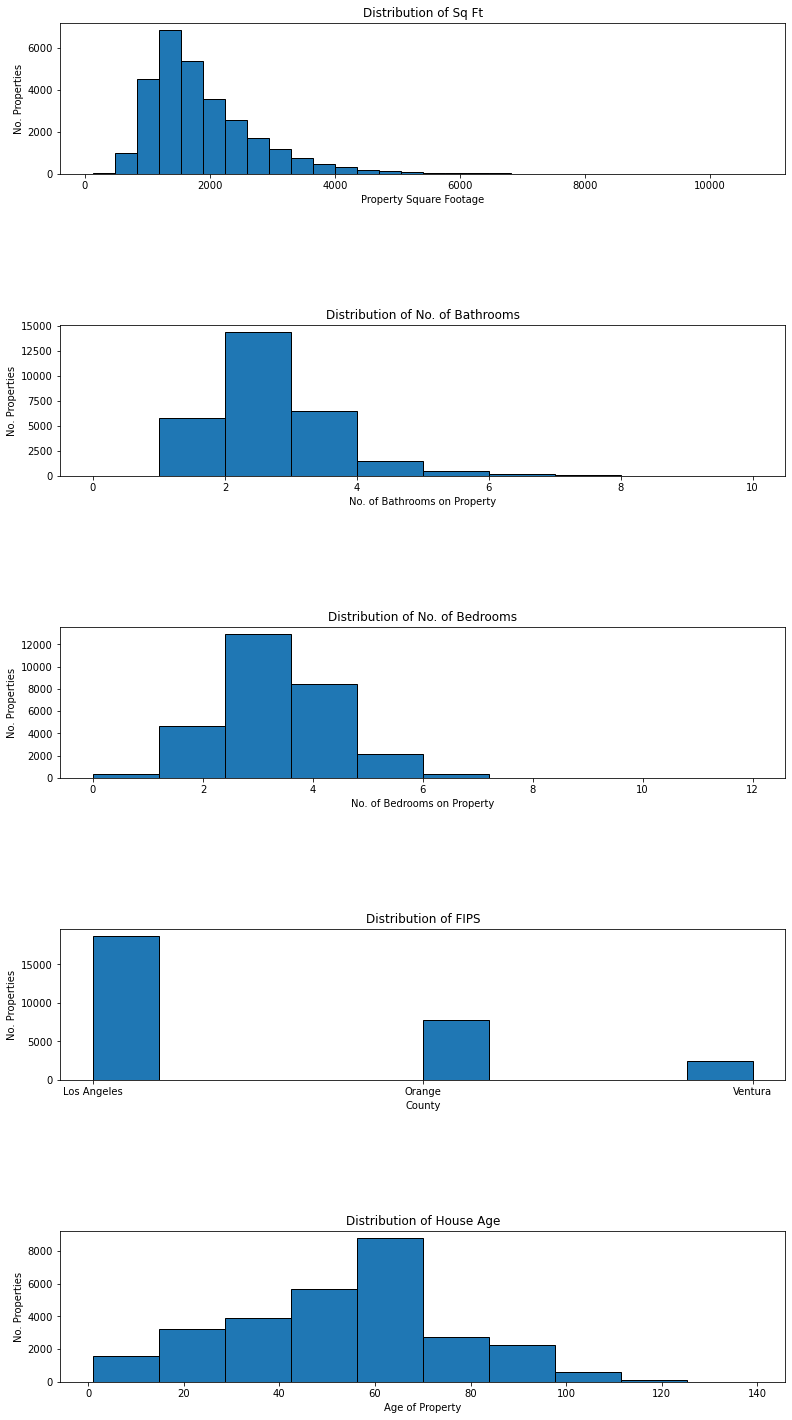

In [16]:
#Checking distributions of our selected features/univariate exploration
exp.distribution_plot(train,cols)

<AxesSubplot:title={'center':'Feautures Correlating with Value'}>

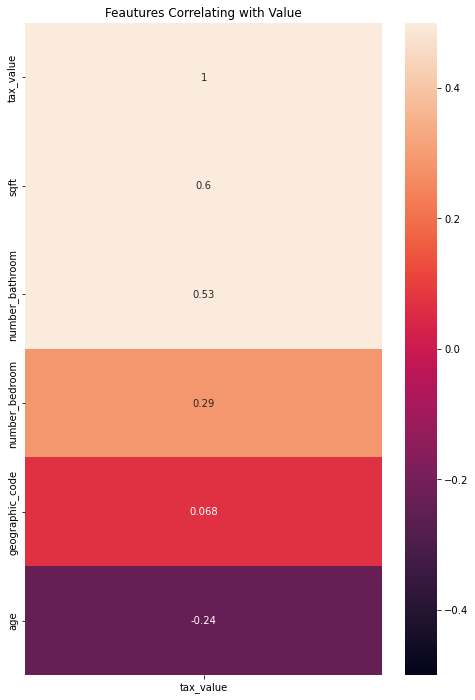

In [17]:
#Plot the features columns to see which has correlation with target varaible
exp.get_zillow_heatmap(train)

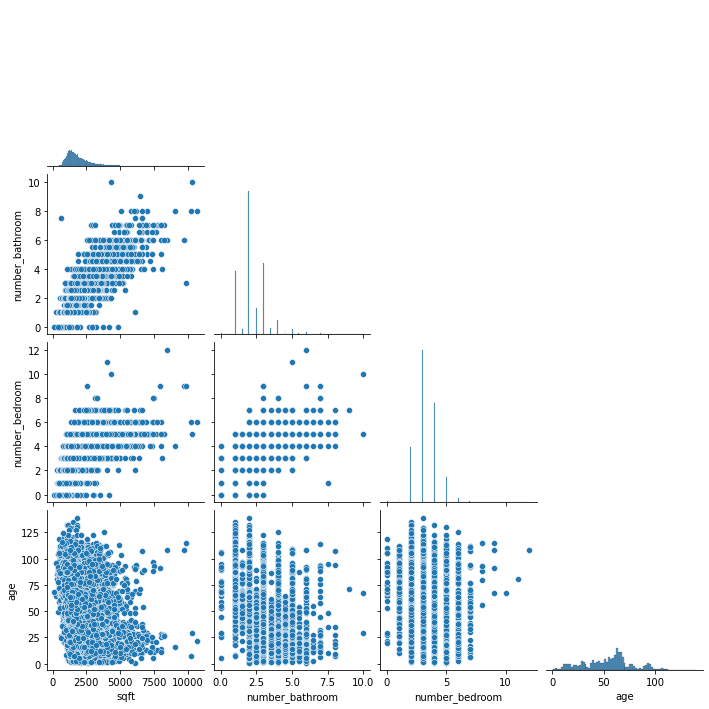

In [18]:
#Create a scatter and histograms
exp.plot_pairplot(train, cols, hue=None)

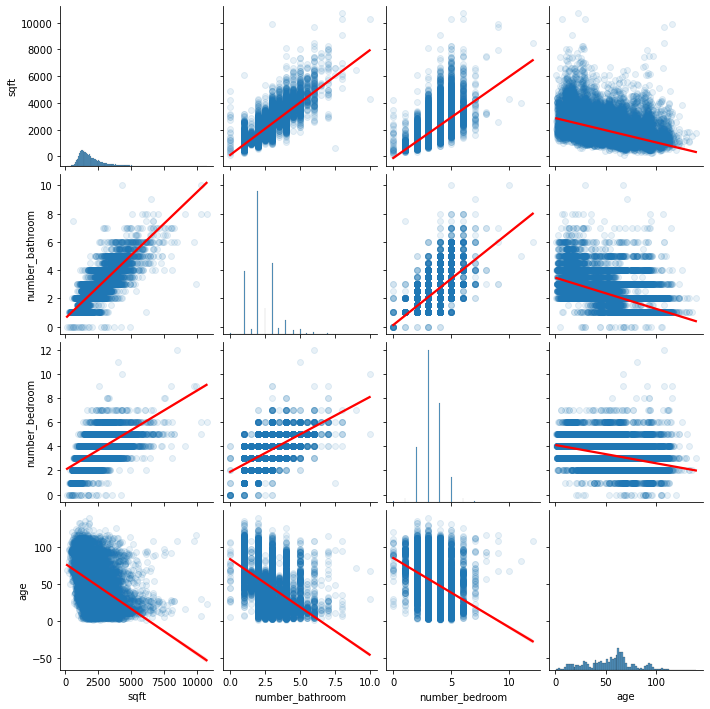

In [19]:
#Pairplots
exp.plot_variable_pairs(train, cols, hue=None)

Take away:
- Most of the property has 3 bedrooms and bathrooms
- Square footage has strong correlation with tax value
- Number_bedroom and number_bathroom have postive correlation with tax_value
- Most of the property was in LA county
- Age has negative correlation
- No. of bedrooms and bathrooms have a positive relationship with each other

## Statistical Test

In [20]:
# a t-test for bedrooms and value
null_hypothesis = "Houses with 3 bedrooms or more and houses with less than 3 bedrooms are independent to value of home"
alternative_hypothesis = "Houses with 3 bedrooms or more and houses with less than 3 bedrooms are related to value of home"
α = 0.05 #a for alpha 
three_or_more_beds = train[train.number_bedroom>=3]
less_than_three_beds = train[train.number_bedroom<3]
t, p = stats.ttest_ind(three_or_more_beds.tax_value, less_than_three_beds.tax_value)

if p < α:
    print(f'Reject null hypothesis that: {null_hypothesis}')
else:
    print(f'Fail to reject null hypothesis that: {null_hypothesis}')

Reject null hypothesis that: Houses with 3 bedrooms or more and houses with less than 3 bedrooms are independent to value of home


The p-value is: 3.067849427056496e-144. There is 0.0% chance that we see these results by chance.
t = 25.72


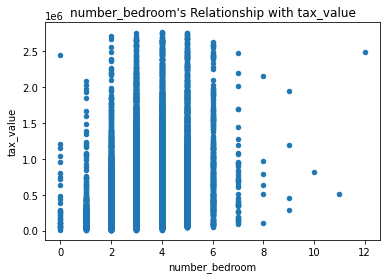

In [21]:
#bedrooms and tax_value
exp.correlation_exploration(train, 'number_bedroom', 'tax_value',t ,p)

In [22]:
# a t test for bathrooms and value, I picked 3 because the mean was over 2. 
# The results suggest they are related to each other.
null_hypothesis = "Houses with 3 bathrooms or more and houses with less than 3 bathrooms are independent to value of home"
alternative_hypothesis = "Houses with 3 bathrooms or more and houses with less than 3 bathrooms are related to value of home"
a = 0.05 #a for alpha 

three_or_more_baths = train[train.number_bathroom>=3]
less_than_three_baths = train[train.number_bathroom<3]
t, p = stats.ttest_ind(three_or_more_baths.tax_value, less_than_three_baths.tax_value)

if p < a:
    print(f'Reject null hypothesis that: {null_hypothesis}')
else:
    print(f'Fail to reject null hypothesis that: {null_hypothesis} There is not sufficient evidence to reject it.')

Reject null hypothesis that: Houses with 3 bathrooms or more and houses with less than 3 bathrooms are independent to value of home


The p-value is: 0.0. There is 0.0% chance that we see these results by chance.
t = 77.78


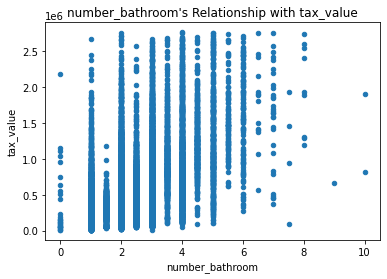

In [23]:
#bathrooms and tax_value
exp.correlation_exploration(train, 'number_bathroom', 'tax_value',t ,p)

In [24]:
# a t test for age, I picked 10 because I would say any house made within the decade is considered fairly new. 
# The results suggest there is not much of a difference in value of homes depending on age. 
null_hypothesis = "House age is independent to value of home"
alternative_hypothesis = "A house being 10 years or older, or less than 10 years, have an affect on value"
a = 0.05 #a for alpha 

old_houses = train[train.age>=10]
new_houses = train[train.age<10]
t, p = stats.ttest_ind(old_houses.tax_value, new_houses.tax_value)

if p < a:
    print(f'Reject null hypothesis that: {null_hypothesis}')
else:
    print(f'Fail to reject null hypothesis that: {null_hypothesis} There is not sufficient evidence to reject it.')

Reject null hypothesis that: House age is independent to value of home


The p-value is: 2.261958643045425e-121. There is 0.0% chance that we see these results by chance.
t = -23.54


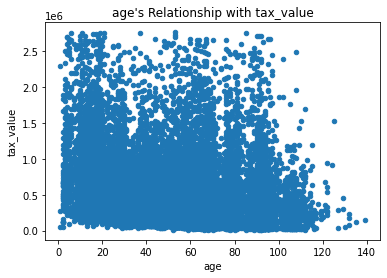

In [25]:
#age and tax_value
exp.correlation_exploration(train, 'age', 'tax_value', t, p)

In [26]:
# t test for square footage and value, I used 1800 sqft because it is roughly the mean area of all selected properties.
# The results suggest they are related to each other.
null_hypothesis = "Values of houses more and less square footage independent to value of home"
alternative_hypothesis = "Values of houses more and less square footage not independent to value of home"
a = 0.05 #a for alpha 

bigger_houses = train[train.sqft>=1800]
smaller_houses = train[train.sqft<1800]
t, p = stats.ttest_ind(bigger_houses.tax_value, smaller_houses.tax_value)

if p < a:
    print(f'Reject null hypothesis that: {null_hypothesis}')
else:
    print(f'Fail to reject null hypothesis that: {null_hypothesis} There is not sufficient evidence to reject it.')

Reject null hypothesis that: Values of houses more and less square footage independent to value of home


The p-value is: 0.0. There is 0.0% chance that we see these results by chance.
t = 80.71


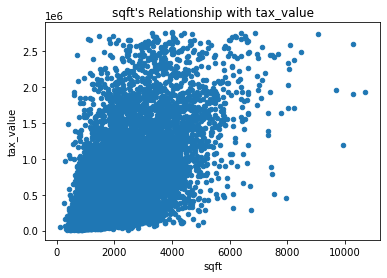

In [27]:
#squared footage and tax_value
exp.correlation_exploration(train, 'sqft', 'tax_value',t ,p)

Takeaways:

- Most distributions are normal or slightly skewed to the right,
- Square footage tends to be bigger for properties with more bedrooms or bathrooms (as expected, sqft, number of beds/baths are all related)
- Age has a negative correlation with tax value, but according to the t test, it may not have a super drastic affect.
- Number of bedrooms and bathrooms have a positive relationship with tax value

## Modeling

- Scale our train, validate and test into X_train, X_validate and X_test with minmaxscaler, we are not scale our target variable
- Put target variable (tax_value) into a dataframe
- Use the scale dataset to create, fit and use the model
- Use rfe to select our features to use for models, since rfe fits mulitple models and figures out what the most impactful features are based on the model and drop the least impact features which is fips (geographic_code)
- Create a baseline by select the one has lowest RMSE between the mean and median
- Select the model base on the feature selected from rfe and our exploratory, the one has lowest rmse in validate and highest r square score and then plot the residual for the best performing model
- Test our best model on unseen data which is X_test and then compare it to the baseline

I choose RMSE and R-Squared as my metric because it is the easiest to interpret since it is expressed in units that are equivalent to our target variable in this case would be US dollars and indicates the percentage of the variance in the dependent variable that the independent variables explain collectively.
The RMSE tells us the standard deviation of the difference between our predictions and the actual values and therefore gives us an idea of how spread out the actual data points are around our regression line. 

In [28]:
#Scaled our data
X_train_scaled, X_validate_scaled, X_test_scaled = w.scaled_df(X_train, X_validate, X_test, MinMaxScaler())

In [29]:
#turning my y_train, y_validate and y_test to dataframes so we can append new columns
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)
y_test = pd.DataFrame(y_test)

In [30]:
#let's find out which four it wants us to use since our explore gave us an idea which four have correlation with tax_value
selected_features = m.select_rfe(X_train_scaled, y_train, 4, LinearRegression())

The top 4 selected feautures based on the the RFE class are: ['number_bedroom', 'number_bathroom', 'sqft', 'age']
number_bedroom     1
number_bathroom    1
sqft               1
age                1
geographic_code    2
dtype: int64


In [31]:
#Create a baseline and select the one has lowest RMSE as our baseline
metric_df, rmse_mean_train, rmse_mean_validate, rmse_median_train, rmse_median_validate, r2_baseline = m.create_baseline(y_train, y_validate, target)

#Linear regression model
rmse_lm_train, rmse_lm_validate, r2_lm_value = m.create_model(LinearRegression(normalize=True), X_train_scaled[selected_features], X_validate_scaled[selected_features], y_train, y_validate)

#Lassorlars model
rmse_lars_train, rmse_lars_validate, r2_lars_value = m.create_model(LassoLars(alpha=1.0), X_train_scaled[selected_features], X_validate_scaled[selected_features], y_train, y_validate)

#Tweedie regressor model
rmse_glm_train, rmse_glm_validate, r2_glm_value = m.create_model(TweedieRegressor(power =0, alpha=0.00), X_train_scaled[selected_features], X_validate_scaled[selected_features], y_train, y_validate)

In [32]:
#making polynomial features to get a new set of features, I found that degree=3 yielded the best results.
pf = PolynomialFeatures(degree=3)

#fit and transform X_train_scaled
X_train_degree3 = pf.fit_transform(X_train_scaled[selected_features])

#transform X_validate_scaled
X_validate_degree3 = pf.transform(X_validate_scaled[selected_features])

In [33]:
#Polymial model
rmse_pf_train, rmse_pf_validate, r2_pf_value = m.create_model(LinearRegression(normalize=True), X_train_degree3, X_validate_degree3, y_train, y_validate)

In [34]:
# add model's performance to metric df
metric_df = metric_df.append({
    'model': 'Linear_regression',
    'rmse_train': rmse_lm_train,
    'rmse_validate': rmse_lm_validate,
    'r^2_value': r2_lm_value}, ignore_index=True)

metric_df = metric_df.append({
    'model': 'Lassolars',
    'rmse_train': rmse_lars_train,
    'rmse_validate': rmse_lars_validate,
    'r^2_value': r2_lars_value}, ignore_index=True)

metric_df = metric_df.append({
    'model': 'Tweedie_regressor',
    'rmse_train': rmse_glm_train,
    'rmse_validate': rmse_glm_validate,
    'r^2_value': r2_glm_value}, ignore_index=True)

metric_df = metric_df.append({
    'model': 'Polynomial_regression',
    'rmse_train': rmse_pf_train,
    'rmse_validate': rmse_pf_validate,
    'r^2_value': r2_pf_value}, ignore_index=True)

In [35]:
#Create a report for side by side comparison to select which model has lowest rmse out of sample
m.report(metric_df)

These are the models that perform better than our baseline rmse: 413818.4728659726


,model,rmse_validate
1,Linear_regression,321334.985074
2,Lassolars,321348.607211
3,Tweedie_regressor,321334.985069
4,Polynomial_regression,316565.929491


-----------------------------------------------------------------------------------------------
   ********** The model with the less  rmse_validate  is Polynomial_regression  rmse:316565.93 **********             
-----------------------------------------------------------------------------------------------
 
The model with r^2 validate closer to 1 is  Polynomial_regression


,model,rmse_train,rmse_validate,r^2_value
0,Mean Baseline,413268.163083,413818.472866,-0.000122
1,Linear_regression,324177.799545,321334.985074,0.396955
2,Lassolars,324178.208202,321348.607211,0.396904
3,Tweedie_regressor,324177.799545,321334.985069,0.396955
4,Polynomial_regression,318899.434281,316565.929491,0.414723


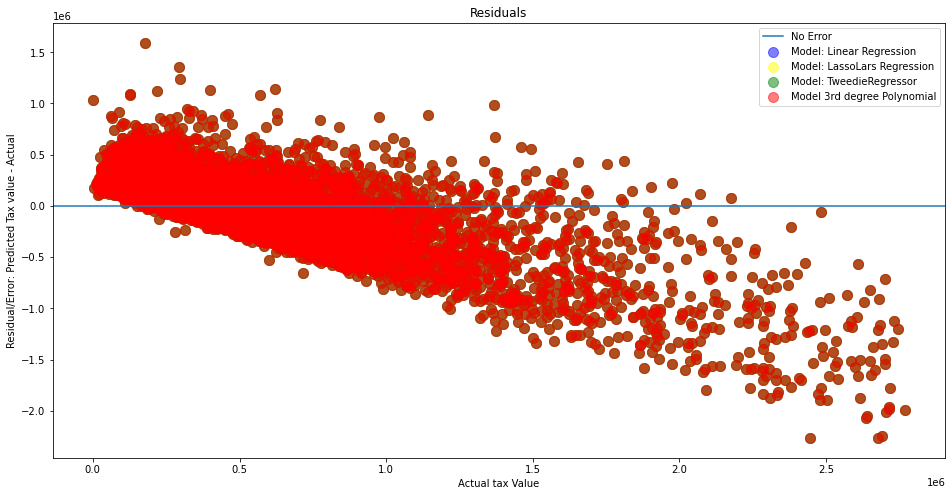

In [36]:
#Plot residuals for all models
exp.plot_residuals(y_validate)

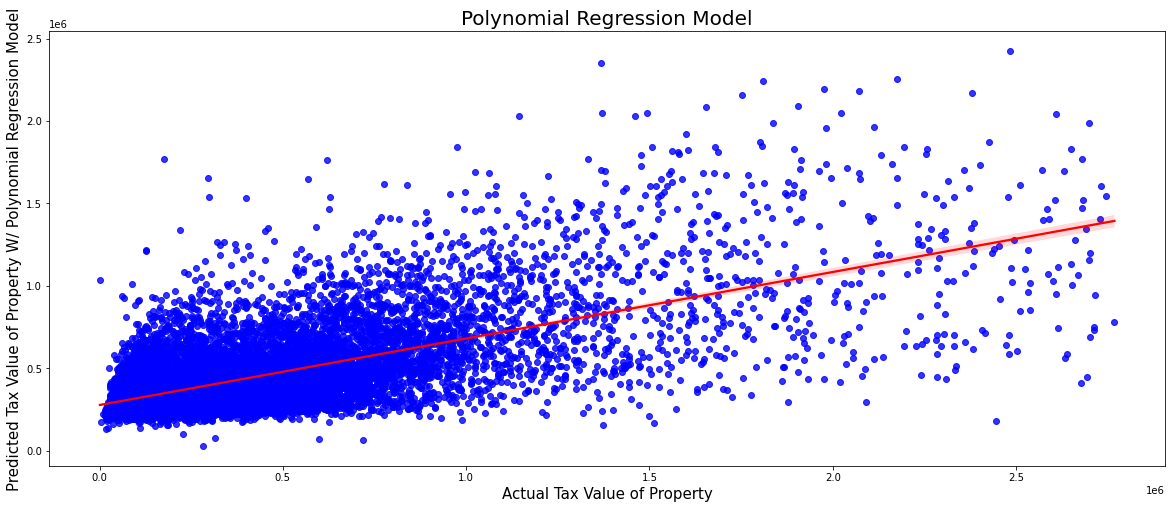

In [37]:
#looks like 3rd degree polynomial did the best, let's visualize that
exp.plot_polynomial(y_test, y_validate)

Take away:
- The graph is going to visualize our residuals (the errors). The closer a dot is to the line means the closer the prediction was to the actual value
- Most of our models are better than our baseline (413,818.47). However our 3rd degree polynomial regression performed the best, it has lowest rmse and highest r square

## Test our best model

In [38]:
#Test the best model
#Best model: 3rd degree polynomial
#Transform our X_test_scaled with selected features
X_test_degree3 = pf.transform(X_test_scaled[selected_features])
rmse_test, r2_test_score = m.best_model(X_test_degree3, y_test)

In [39]:
#Look at the r score and rmse
r2_test_score,rmse_test

(0.4006944135449666, 323772.4908467305)

In [40]:
#Drop other column in metric df except the best model
best_model = metric_df.drop([1,2,3], axis = 0)

In [41]:
#Add a column for test so we can compare it with the baseline
best_model['rmse_test'] = rmse_test
best_model.iloc[0,4] = 0

In [42]:
best_model

,model,rmse_train,rmse_validate,r^2_value,rmse_test
0,Mean Baseline,413268.163083,413818.472866,-0.000122,0.000000
4,Polynomial_regression,318899.434281,316565.929491,0.414723,323772.490847


Takeaway:
- Our test model (Polynomial regression, 3 degrees) performs 78% better than the baseline. It has a lower RMSE, lower variance between test/validate, and has a higher r^2 value, so it can better explain the variances between predicted and actual home values.
- Square footage was the best feature for predicting home value, followed up by bathrooms and bedrooms.

### Conclusions, Next Steps...

To conclude... We took a very large Zillow dataset to work with. Dropped to 52200 rows by remove some missing values and duplicates, remove outliers of 3 standard deviations above or below the mean for that column.

    - Square footage was the best feature to determine a property's value. As square footage increased, it seemed that value also went up.

    - The more bedrooms and bathrooms a house has, the more it was worth. These number of rooms also related to square footage in a positive relationship.

    - Age was not a huge factor in value, but was helpful in our model's predictions.

    - Using all of number of bedrooms, number of bathrooms, square footage and age into a model performed better than the baseline.

With more time, I would definitely look into the other columns and see if they could contribute positively to our prediction model with some cleaning up on nulls and outliers. I believe location is still a huge factor on value, so I'd try to work with columns like latitude/longitude, zip code, etc. as FIPS was not a great indicator for value on how general it is.